# Group1 Consulting
## See Through the Ambiguity: Predicting Home Prices

Group1 Consulting has been approached by a real estate investement agency who is requesting an algorithm that predicts home prices. The real estate investment firm FlatTech RealEstate, buys homes in the Austin area. They have tasked our team with finding a datafile, clean it, and run various algorithms to create an home price predictor. Our algorith will predict home prices based on common features of home listings like number of beds, baths, lot size, square footage, etc. to help both buyers and sellers see through the ambiguity in home pricing.

This notebook is being run in Google Co-Lab for versioning control.

## The Dataset
The dataset we're using is the Austin TX, House Listing dataset off Kaggle, created by Eric Pierce. The dataset has been uploaded to one of our teams branches so we'll drill into here to upload it to the notebook. Here is the link to the actual Kaggle page:
https://www.kaggle.com/datasets/ericpierce/austinhousingprices

In [1]:
# Use wget to pull in the dataset into the notebook
!wget https://raw.githubusercontent.com/hixtape1212/Group1Capstone/Gerardo/Austin_notebooks/austinHousingData.csv

--2023-08-03 01:23:10--  https://raw.githubusercontent.com/hixtape1212/Group1Capstone/Gerardo/Austin_notebooks/austinHousingData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11389525 (11M) [text/plain]
Saving to: ‘austinHousingData.csv.5’

austinHousingData.c 100%[===================>]  10.86M  63.0MB/s    in 0.2s    

2023-08-03 01:23:11 (63.0 MB/s) - ‘austinHousingData.csv.5’ saved [11389525/11389525]



### Importing the Nessesary Librarys for Analysis
Since Kera's is required to create Nueral Networks later in this notebook, we need to control versioning, which is why Google Co-Lab is the prime choice to run this notebook. Below we'll import the nessesary libraries.

In [2]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from yellowbrick.regressor import PredictionError
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.api._v2.keras import activations
from tensorflow.keras.optimizers.schedules import ExponentialDecay

print(tf.__version__)

2.12.0


In [3]:
#Creating a dataframe for the dataset
file_path = 'austinHousingData.csv'
df = pd.read_csv(file_path)

## EDA and Cleaning
Let's take a look at the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zpid                        15171 non-null  int64  
 1   city                        15171 non-null  object 
 2   streetAddress               15171 non-null  object 
 3   zipcode                     15171 non-null  int64  
 4   description                 15171 non-null  object 
 5   latitude                    15171 non-null  float64
 6   longitude                   15171 non-null  float64
 7   propertyTaxRate             15171 non-null  float64
 8   garageSpaces                15171 non-null  int64  
 9   hasAssociation              15171 non-null  bool   
 10  hasCooling                  15171 non-null  bool   
 11  hasGarage                   15171 non-null  bool   
 12  hasHeating                  15171 non-null  bool   
 13  hasSpa                      151

Initially we see that the data is very clean, with no non-null values. Our client is only interested in single family homes. Let's get rid of any homes that don't fit that description.

In [5]:
#Let's look at the home types. We primarily only want single family homes
df.homeType.value_counts()

Single Family            14241
Condo                      470
Townhouse                  174
Multiple Occupancy          96
Vacant Land                 83
Residential                 37
Apartment                   37
Mobile / Manufactured       17
MultiFamily                 10
Other                        6
Name: homeType, dtype: int64

In [6]:
df = df[df.homeType == 'Single Family']
df.shape

(14241, 47)

 Also, for our purposes columns like zpid which is the default primary key zillow uses to identify homes can be gotten rid of. Additionally it would be good to only use numeric values as they are the only values our models can use to train.

Most of the object types here are redudant and the information gathered can be explained by another numeric feature, like City can be explained through zip code etc. We can drop those.

Also boolean values can be changed into numeric 0 and 1 for our processing purposes. We can do both of these things below.

In [7]:
#Drop object columns as well as zipid
col_drop_list = df.select_dtypes(include=[np.object]).keys()
col_drop_list = col_drop_list.union(['zpid'])
df = df.drop(col_drop_list, axis=1)
df.shape

<ipython-input-7-421071a199b5>:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  col_drop_list = df.select_dtypes(include=[np.object]).keys()


(14241, 39)

In [8]:
#Changing Booleans to int values, then dropping the boolean columns
col_bool_list = ['hasAssociation', 'hasCooling',
                 'hasGarage', 'hasHeating', 'hasSpa', 'hasView']

for col in col_bool_list:
    name = col + '_int'
    df[name] = df[col].astype(int)

df = df.drop(col_bool_list, axis=1)
df.shape

(14241, 39)

### Dealing with Outliers
Now that our dataset is all numeric, let's take a look at the key feature statistics and see if their are any heavy outliers. Keep in mind we're trying to predict home pricing.

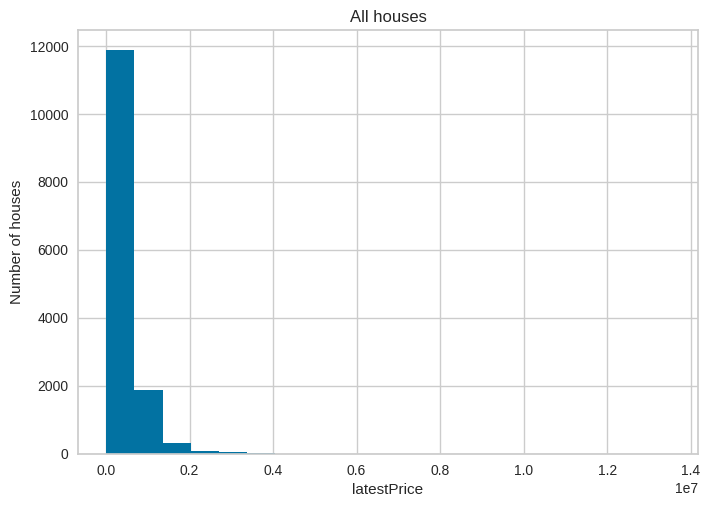

In [9]:
# Plot latestPrice
plt.hist(df['latestPrice'], bins=20)
plt.xlabel('latestPrice')
plt.ylabel('Number of houses')
plt.title('All houses')
plt.show()

In [10]:
#Take a look at the descriptive stats
df.describe().transpose().apply(lambda x: x.apply('{0:f}'.format))

,count,mean,std,min,25%,50%,75%,max
zipcode,14241.000000,78736.186785,18.721340,78617.000000,78727.000000,78739.000000,78749.000000,78759.000000
latitude,14241.000000,30.291740,0.098383,30.085030,30.201195,30.284163,30.367920,30.517174
longitude,14241.000000,-97.780411,0.085880,-98.022057,-97.841804,-97.771988,-97.718689,-97.569504
propertyTaxRate,14241.000000,1.994731,0.054207,1.980000,1.980000,1.980000,1.980000,2.210000
garageSpaces,14241.000000,1.236851,1.343474,0.000000,0.000000,1.000000,2.000000,20.000000
parkingSpaces,14241.000000,1.236219,1.343612,0.000000,0.000000,1.000000,2.000000,20.000000
yearBuilt,14241.000000,1988.408749,21.555337,1905.000000,1974.000000,1993.000000,2006.000000,2020.000000
latestPrice,14241.000000,516387.884629,446969.176124,5500.000000,310000.000000,409900.000000,575000.000000,13500000.000000
numPriceChanges,14241.000000,3.044730,2.491960,1.000000,1.000000,2.000000,4.000000,23.000000
latest_salemonth,14241.000000,6.728039,3.134325,1.000000,4.000000,7.000000,9.000000,12.000000


If you notice, the latest prices ranges from 5500 dollars to 13.5 million! This is a large gap and could heavily skew our model. Let's look and see if we can narrow that down by looking at the column on a normal distribution and finding the inner 90 and 95 percent ranges.

In [11]:
#Narrowing this down can help our model. Lets look at the mid 80 & 90%
upper = np.percentile(df.latestPrice, 90)
lower = np.percentile(df.latestPrice, 10)

print('Middle 80 are values between {} and {}'.format(lower, upper))

upper = np.percentile(df.latestPrice, 95)
lower = np.percentile(df.latestPrice, 5)

print('Middle 90 are values between {} and {}'.format(lower, upper))

Middle 80 are values between 240000.0 and 840000.0
Middle 90 are values between 207000.0 and 1175000.0


The middle 90% of the home values are between 207,000 and 1,175,000. If we move the lower bound down I think we should be looking at home from 200,000 to 1.1 million, covering roughly 90% of our data.

In [12]:
#Dropping values between 200k and 1.175M
df = df.drop(df[df['latestPrice'] < 200000].index)
df = df.drop(df[df['latestPrice'] > 1175000].index)
df.shape

(12907, 39)

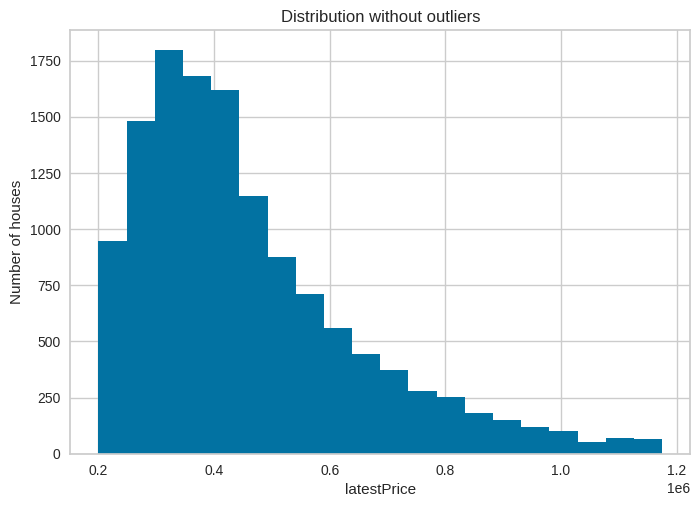

In [13]:
# Plot latestPrice after delete outliers
plt.hist(df['latestPrice'], bins=20)
plt.xlabel('latestPrice')
plt.ylabel('Number of houses')
plt.title('Distribution without outliers')
plt.show()

# Looking at potential additional Outliers in Features

In [14]:
def value_counts_for_dataframe(df):
    column_value_counts = {}
    for col in df.columns:
        column_value_counts[col] = df[col].value_counts()
    return column_value_counts

# Example usage:
if __name__ == "__main__":
    # Assuming you have a pandas DataFrame called 'your_dataframe'
    # Replace this with your actual DataFrame
    your_dataframe = pd.DataFrame({
        'Column1': [1, 2, 3, 1, 2],
        'Column2': ['A', 'B', 'C', 'A', 'A'],
        'Column3': [True, False, True, False, True]
    })

    # Get value counts for each column in the DataFrame
    result = value_counts_for_dataframe(df)

    # Print the value counts for each column
    for col, value_counts in result.items():
        print(f"Value counts for {col}:")
        print(value_counts)
        print()

Value counts for zipcode:
78748    1056
78745     932
78749     755
78739     600
78737     595
78732     544
78717     502
78759     501
78723     471
78757     465
78704     453
78727     389
78744     380
78753     375
78731     373
78747     349
78754     340
78702     334
78758     334
78750     302
78729     299
78735     224
78728     205
78721     204
78724     179
78726     173
78730     171
78733     158
78736     155
78741     152
78751     149
78703     142
78752     127
78756     113
78746      92
78725      91
78722      90
78617      38
78660      34
78705      32
78619      11
78734       5
78652       4
78742       3
78719       2
78653       2
78738       1
78701       1
Name: zipcode, dtype: int64

Value counts for latitude:
30.179701    4
30.196487    4
30.179668    4
30.375725    3
30.354153    3
            ..
30.194519    1
30.186815    1
30.157265    1
30.166956    1
30.276930    1
Name: latitude, Length: 12336, dtype: int64

Value counts for longitude:
-97.7286

In [15]:
def drop_rows_containing_values(df, column_name, values_to_drop):
    return df[~df[column_name].isin(values_to_drop)]

In [16]:
# Dropping outliers in zipcode
df = drop_rows_containing_values(df, 'zipcode', [78734, 78652, 78719, 78653, 78738, 78701])
df.shape

(12892, 39)

In [17]:
# Dropping Price Change outliers
df = drop_rows_containing_values(df, 'numPriceChanges', [17, 19, 18, 23, 22, 20])
df.shape

(12877, 39)

In [18]:
# Dropping appliance outliers
df = drop_rows_containing_values(df, 'numOfAppliances', [10,54])
df.shape

(12876, 39)

In [19]:
# Dropping Parking Features outliers
df = drop_rows_containing_values(df, 'numOfParkingFeatures', [6,5])
df.shape

(12855, 39)

In [20]:
# Dropping Patio Features outliers
df = drop_rows_containing_values(df, 'numOfPatioAndPorchFeatures', [6,7,8])
df.shape

(12848, 39)

In [21]:
# Dropping Security Features outliers
df = drop_rows_containing_values(df, 'numOfSecurityFeatures', [5,6])
df.shape

(12832, 39)

In [22]:
# Dropping Water front outliers
df = drop_rows_containing_values(df, 'numOfWaterfrontFeatures', [2])
df.shape

(12831, 39)

In [23]:
# Dropping primary schools number outliers
df = drop_rows_containing_values(df, 'numOfPrimarySchools', [0,2])
df.shape

(12133, 39)

In [24]:
# Dropping num of elementary schools outliers
df = drop_rows_containing_values(df, 'numOfElementarySchools', [1,2])
df.shape

(12133, 39)

In [25]:
# Dropping Middle School outliers
df = drop_rows_containing_values(df, 'numOfMiddleSchools', [2,3,0])
df.shape

(12128, 39)

In [26]:
# Dropping Students per teacher outliers
df = drop_rows_containing_values(df, 'MedianStudentsPerTeacher', [10,19])
df.shape

(12087, 39)

## Final Pre-Processing

Lineal regression needs a symetric distribution and we will apply a logarithmic function for this, in other hand Neural network doesn't need a symmetric distribution, with a normalization it's enough.
Different models need different processing.


## Linear Regression

As we can see in the plot above we have an asymmetric distribution and to fix it we'll apply a logarithmic function.

In [27]:
# Applying logarithmic funtion
transformer = FunctionTransformer(np.log1p, validate=True)
df_log = transformer.transform(df)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:310: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


In [28]:
# Making a new dataframe with logarithmic data
columns_names = df.columns

df_log = pd.DataFrame(df_log, columns= columns_names)
df_log.head(3)

,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,numPriceChanges,latest_salemonth,...,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,hasAssociation_int,hasCooling_int,hasGarage_int,hasHeating_int,hasSpa_int,hasView_int
0,11.272903,3.447783,NaN,1.091923,1.098612,1.098612,7.607381,12.628070,1.791759,2.302585,...,2.70805,1.386294,1.609438,1.098612,0.693147,0.693147,0.693147,0.693147,0.0,0.0
1,11.272903,3.447848,NaN,1.091923,1.098612,1.098612,7.607878,12.594734,0.693147,2.397895,...,2.70805,1.098612,1.609438,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0
2,11.272903,3.447830,NaN,1.091923,1.098612,1.098612,7.607878,12.388398,1.609438,2.197225,...,2.70805,1.098612,1.386294,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0


 Column 'longitude' had negative numbers, after applying the logarithmic function data became NaN, so we have to delete it

In [29]:
# Delete longitude column
df_log = df_log.drop('longitude', axis=1)

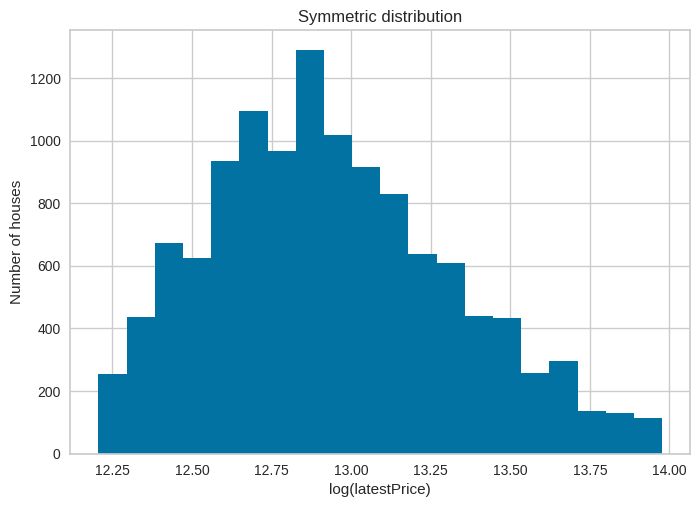

In [30]:
# Plot latestPrice after logarithmic function
plt.hist(df_log['latestPrice'], bins=20)
plt.xlabel('log(latestPrice)')
plt.ylabel('Number of houses')
plt.title('Symmetric distribution')
plt.show()

#### Let's see if we have multicollinearity

In [31]:
# Correlation with latestPrice column
df.corr()['latestPrice']

zipcode                      -0.208835
latitude                      0.114577
longitude                    -0.246001
propertyTaxRate              -0.060918
garageSpaces                  0.147653
parkingSpaces                 0.147314
yearBuilt                    -0.054305
latestPrice                   1.000000
numPriceChanges               0.031807
latest_salemonth              0.049759
latest_saleyear               0.073102
numOfPhotos                   0.171837
numOfAccessibilityFeatures    0.010583
numOfAppliances               0.041009
numOfParkingFeatures          0.100491
numOfPatioAndPorchFeatures    0.109750
numOfSecurityFeatures         0.079664
numOfWaterfrontFeatures       0.019328
numOfWindowFeatures           0.111921
numOfCommunityFeatures        0.006126
lotSizeSqFt                   0.039274
livingAreaSqFt                0.549115
numOfPrimarySchools                NaN
numOfElementarySchools             NaN
numOfMiddleSchools                 NaN
numOfHighSchools         

We dont have multicollinearity

#### Train and Test splits

In [32]:
#Creating Train and Test splits
X = df_log.drop('latestPrice', axis='columns')
y = df_log.latestPrice
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    random_state=42)

In [33]:
# Creating the model
lr = LinearRegression()

In [34]:
# Get model results
lr.fit(X_train, y_train)

LinearRegression()

In [35]:
# Apply model in X_test
prediction_test = lr.predict(X_test)

#### Evaluation

In [36]:
# Get coefficient of determination
r_squared = r2_score(y_test, prediction_test)
r_squared

0.6069196718892995

Coefficient of determination is 0.60, in other words this model is explaining only the 60% of data.

60% it's not enough for our purposes, so we will use another technique called XGBRegressor

In [37]:
# MAE
print('Mean Absolute Error: {}'.format(round(mean_absolute_error(np.expm1(y_test), np.expm1(prediction_test)), 3)))

Mean Absolute Error: 82174.392


## XGBRegressor

In [38]:
# Creating the model
xgbr = XGBRegressor(random_state=42, max_depth=8, n_estimators=40)

In [39]:
# Get model results
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=40, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [40]:
# Apply model in X_test
pred_test_xgbr = xgbr.predict(X_test)

#### Evaluation

In [41]:
# Get coefficient of determination
r_squared = r2_score(y_test, pred_test_xgbr)
r_squared

0.7977700847754179

Now the coefficient of determination is 0.78, in other words this model is explaining the 78% of data.

The model with XGBRegressor has a better performance than the Lineal regression.

Now let's see the "prediction error plot" that shows the actual data from the dataset against the predicted values generated by our model. This allows us to see how much variance is in our model

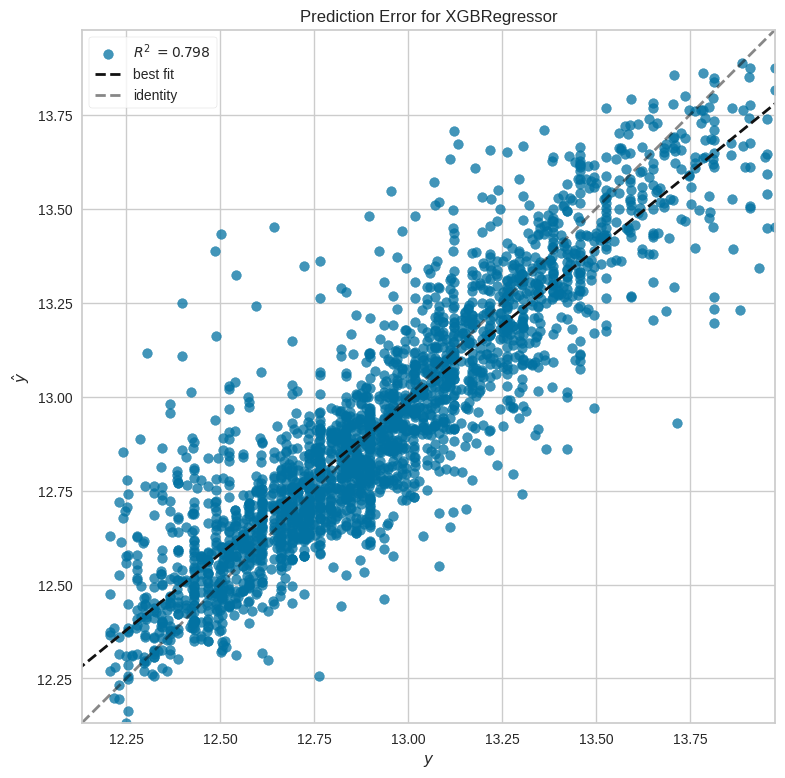

In [42]:
# Prediction Error for our model: XGBRegressor
fig, ax = plt.subplots(figsize=(9,9)) # size plot
visualizer = PredictionError(xgbr) # instantiate visualizer

visualizer.fit(X_train, y_train) # Fit training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
visualizer.show() # Finalize and render the figure
plt.show()

#### Cross validation

Now to be sure that our model is not overfitting, we will apply cross validation with 5 splits.

In [43]:
# Defining k-number of subsets
cv = KFold(n_splits = 5, shuffle = True)

# Applying cross validation to get R^2
accuracyXGBR_cross_val_r2 = cross_val_score(estimator = xgbr,
                                       X = X_train,
                                       y = y_train,
                                       scoring = 'r2',
                                       cv = cv)
accuracyXGBR_cross_val_r2

array([0.77607467, 0.80474259, 0.76282485, 0.80124263, 0.77949601])

We have precision in the five R^2 results, we don't have overfitting.

In [44]:
# Get mean five R^2 results
print('Mean of cross validation results: {}'.format(round(accuracyXGBR_cross_val_r2.mean(), 3)))

Mean of cross validation results: 0.785


Evaluation with Mean Absolute Error

In [45]:
# MAE
print('Mean Absolute Error: {}'.format(round(mean_absolute_error(np.expm1(y_test), np.expm1(pred_test_xgbr)), 3)))

Mean Absolute Error: 55616.496


Now we will apply neural networking and we won't use logarithmic data.

## Neural Networking
The nueral networking approach is more complex than linear regression. Still using RMSE, MSE, and MAE as evaluation metrics, the model can take a long time to compute as well as be hard to interprate exactly what is going on. We will create a basic model first, and start to build more complex model to try and minimize our evaluation metrics.

In [46]:
#Creating Train and Test splits
X = df.drop('latestPrice', axis='columns')
y = df.latestPrice
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    random_state=42)

In [47]:
#Normalizing the input data
sc = MinMaxScaler(feature_range=(0,1))
X_norm_train = sc.fit_transform(X_train)
X_norm_test = sc.fit_transform(X_test)

### Creating a visualization tool
First we'll create a function that takes a model's training history and output two graphs describing the MSE and MAE of our training and validation sets. This way we can easily see visually how the model is performing.

In [48]:
#Creating plotting function to evaluate models
def plot_results(r):
  hist = pd.DataFrame(r.history)
  hist['epoch'] = r.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MAE of House Price')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label='Validation Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MSE of House Price')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label='Validation Error')
  plt.legend()

### Model Creation
Now let's create our first basic model

In [49]:
#First Model with relu as activation, simple architecture, and adam as optimizer
def build_model():
  model = keras.Sequential([
      layers.Dense(40, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
      layers.Dense(20, activation=tf.nn.relu),
      layers.Dense(10, activation=tf.nn.relu),
      layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(
      loss = 'mse',
      optimizer=optimizer,
      metrics=['mae','mse']
  )

  return model

In [50]:
# Instantiate the model and look at summary
v1_model = build_model()
v1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                1560      
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,601
Trainable params: 2,601
Non-trainable params: 0
_________________________________________________________________


Testing set Mean Abs Error: 92211.28 dollars
Testing set Root Mean Squared Error: 130457.54 dollars


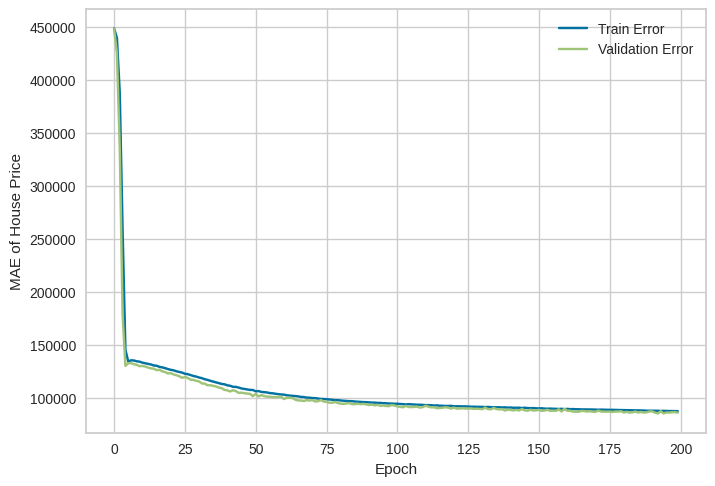

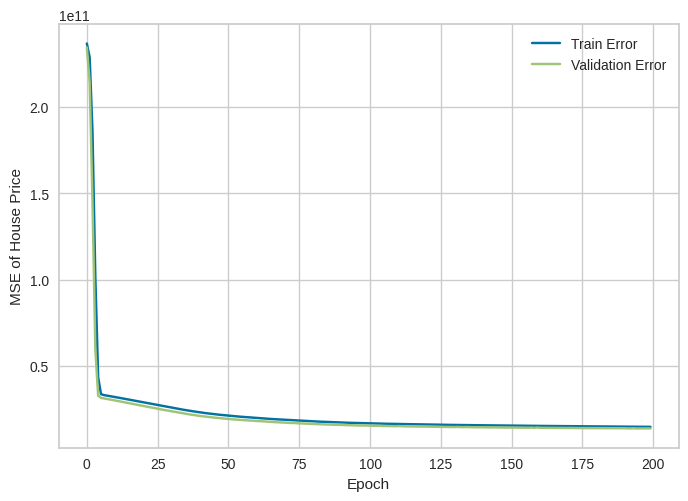

In [51]:
#Train and view model results
v1_history = v1_model.fit(X_norm_train, y_train,
                          epochs=200,
                          validation_split=.2,
                          verbose=0)
plot_results(v1_history)

v1_loss, v1_mae, v1_mse = v1_model.evaluate(X_norm_test, y_test, verbose=0)

print('Testing set Mean Abs Error: {:5.2f} dollars'.format(v1_mae))
print('Testing set Root Mean Squared Error: {:5.2f} dollars'.format(np.sqrt(v1_mse)))

Overall the model seemed to perform well. It starts to bottom out on performance after 50 epochs, so it might be useful to add in a dynamic of early stopping to the model in order to stop it from overtraining and taking longer than it needs too.

In [52]:
# Create the early stopping callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [53]:
# Create a new model with Early Stopping
def build_model():
  model = keras.Sequential([
      layers.Dense(40, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
      layers.Dense(20, activation=tf.nn.relu),
      layers.Dense(10, activation=tf.nn.relu),
      layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(
      loss = 'mse',
      optimizer=optimizer,
      metrics=['mae','mse'],
  )

  return model

In [54]:
# Instantiate the model and look at summary
v2_model = build_model()
v2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 40)                1560      
                                                                 
 dense_5 (Dense)             (None, 20)                820       
                                                                 
 dense_6 (Dense)             (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,601
Trainable params: 2,601
Non-trainable params: 0
_________________________________________________________________


Testing set Mean Abs Error: 91968.21 dollars
Testing set Root Mean Squared Error: 129952.37 dollars


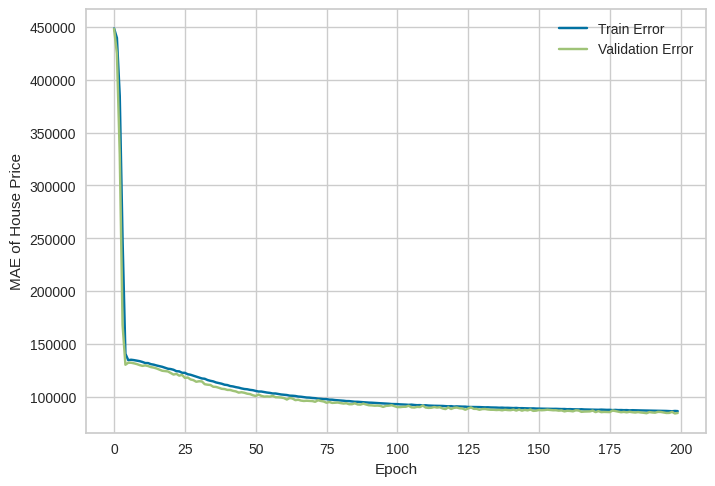

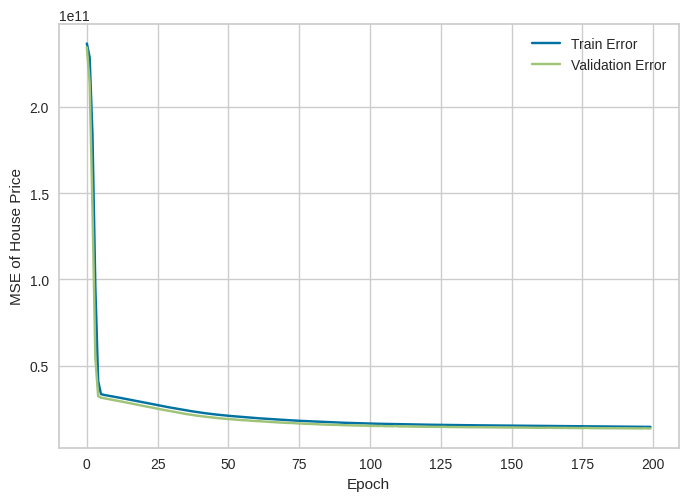

In [55]:
#Train and view model results, with early stopping
v2_history = v2_model.fit(X_norm_train, y_train,
                          epochs=200,
                          validation_split=.2,
                          verbose=0,
                          callbacks=[early_stop])
plot_results(v2_history)

v2_loss, v2_mae, v2_mse = v2_model.evaluate(X_norm_test, y_test, verbose=0)

print('Testing set Mean Abs Error: {:5.2f} dollars'.format(v2_mae))
print('Testing set Root Mean Squared Error: {:5.2f} dollars'.format(np.sqrt(v2_mse)))

The model seemed to have performed better in terms of MAE and RMSE, but the early stopping never kicked in. Let's make the model more complex, with longer epochs and a deeper network and see if we can again reduce the MAE and RMSE.

In [56]:
# Create a more complex model
def build_model():
  model = keras.Sequential([
      layers.Dense(350, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
      layers.Dense(175, activation=tf.nn.relu),
      layers.Dense(100, activation=tf.nn.relu),
      layers.Dense(50, activation=tf.nn.relu),
      layers.Dense(25, activation=tf.nn.relu),
      layers.Dense(10, activation=tf.nn.relu),
      layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(
      loss = 'mse',
      optimizer=optimizer,
      metrics=['mae','mse'],
  )

  return model

In [57]:
# Instantiate the model and look at summary
v3_model = build_model()
v3_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 350)               13650     
                                                                 
 dense_9 (Dense)             (None, 175)               61425     
                                                                 
 dense_10 (Dense)            (None, 100)               17600     
                                                                 
 dense_11 (Dense)            (None, 50)                5050      
                                                                 
 dense_12 (Dense)            (None, 25)                1275      
                                                                 
 dense_13 (Dense)            (None, 10)                260       
                                                                 
 dense_14 (Dense)            (None, 1)                

Testing set Mean Abs Error: 69942.04 dollars
Testing set Root Mean Squared Error: 110299.57 dollars


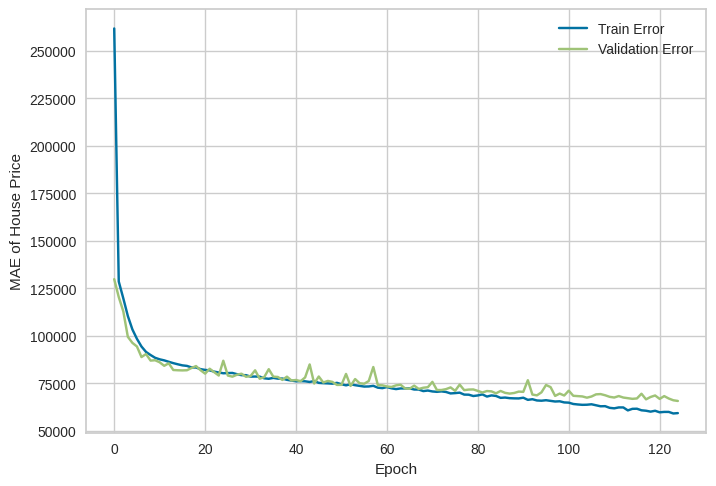

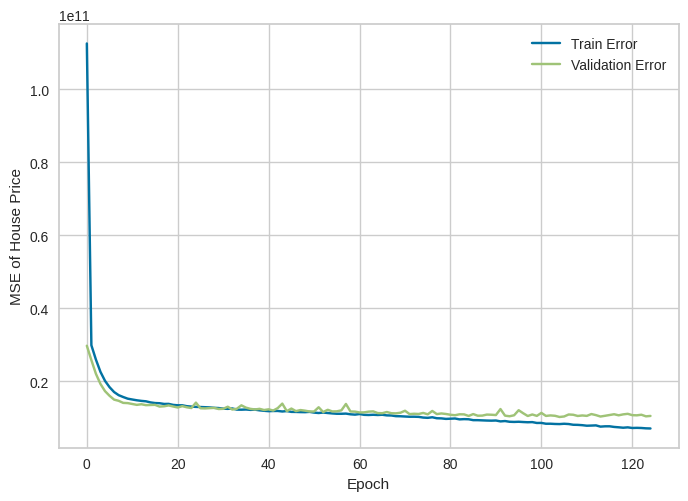

In [58]:
#Train and view model results, with early stopping
v3_history = v3_model.fit(X_norm_train, y_train,
                          epochs=200,
                          validation_split=.2,
                          verbose=0,
                          callbacks=[early_stop])
plot_results(v3_history)

v3_loss, v3_mae, v3_mse = v3_model.evaluate(X_norm_test, y_test, verbose=0)

print('Testing set Mean Abs Error: {:5.2f} dollars'.format(v3_mae))
print('Testing set Root Mean Squared Error: {:5.2f} dollars'.format(np.sqrt(v3_mse)))

The larger model seems to have produced fairly decent results but had a showing of overfitting towards the end of the epochs. Let's take this a step further and create a much bigger model, but add in a few components of BatchNormalization to prevent overfitting as well as early stopping in case the model stops performing better.

In [59]:
# Early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#New model with an adjusted learning rate and BatchNormalization
def build_model():
  model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(X_train.keys())]),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1)
  ])

  optimizer = keras.optimizers.Adam(learning_rate=0.001)

  model.compile(
      loss = 'mean_absolute_error',
      optimizer=optimizer,
      metrics=['mae','mse']
  )

  return model

model = build_model()

In [60]:
# Instantiate the model and look at summary
v4_model = build_model()
v4_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               9984      
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_6 (Batc  (None, 128)             

Testing set Mean Abs Error: 103647.84 dollars
Testing set Root Mean Squared Error: 155067.87 dollars


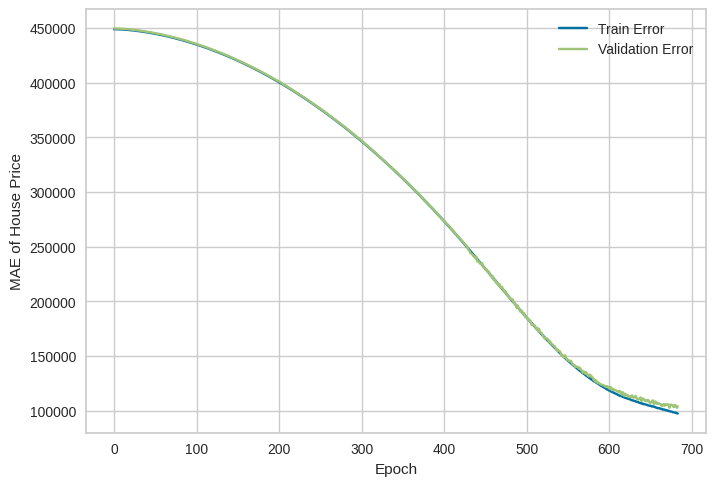

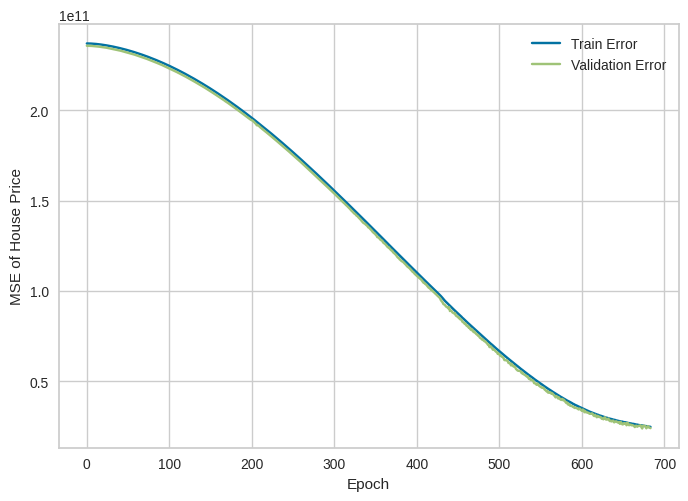

In [61]:
#Train the model
v4_history = v4_model.fit(X_norm_train,
                           y_train,
                           batch_size=64,
                           epochs=1000,
                           validation_split=.2,
                           verbose=0,
                           callbacks=[early_stop])

plot_results(v4_history)

#Overall looks pretty good, let's see what kind of RMSE and MAE we're getting
v4_loss, v4_mae, v4_mse = v4_model.evaluate(X_norm_test, y_test, verbose=0)

print('Testing set Mean Abs Error: {:5.2f} dollars'.format(v4_mae))
print('Testing set Root Mean Squared Error: {:5.2f} dollars'.format(np.sqrt(v4_mse)))

Overall this model definitely began to perform better, but the performance fell off around 700 epochs, kicking in our early stopping. With MAE of 103,000 it would be better to use our best model and attempt to prevent overfitting. Let's run one more model and add dropout layers to help with overfitting at the end and see if that improves the result.

In [65]:
# CUse best model with an emphasis on not overfitting
def build_model():
  model = keras.Sequential([
      layers.Dense(350, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
      layers.Dropout(.2),
      layers.Dense(175, activation=tf.nn.relu),
      layers.Dropout(.2),
      layers.Dense(100, activation=tf.nn.relu),
      layers.Dropout(.2),
      layers.Dense(50, activation=tf.nn.relu),
      layers.Dropout(.2),
      layers.Dense(25, activation=tf.nn.relu),
      layers.Dropout(.2),
      layers.Dense(10, activation=tf.nn.relu),
      layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(
      loss = 'mse',
      optimizer=optimizer,
      metrics=['mae','mse'],
  )

  return model

In [66]:
# Instantiate the model and look at summary
v5_model = build_model()
v5_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 350)               13650     
                                                                 
 dropout_5 (Dropout)         (None, 350)               0         
                                                                 
 dense_33 (Dense)            (None, 175)               61425     
                                                                 
 dropout_6 (Dropout)         (None, 175)               0         
                                                                 
 dense_34 (Dense)            (None, 100)               17600     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_35 (Dense)            (None, 50)               

Testing set Mean Abs Error: 101748.66 dollars
Testing set Root Mean Squared Error: 134470.37 dollars


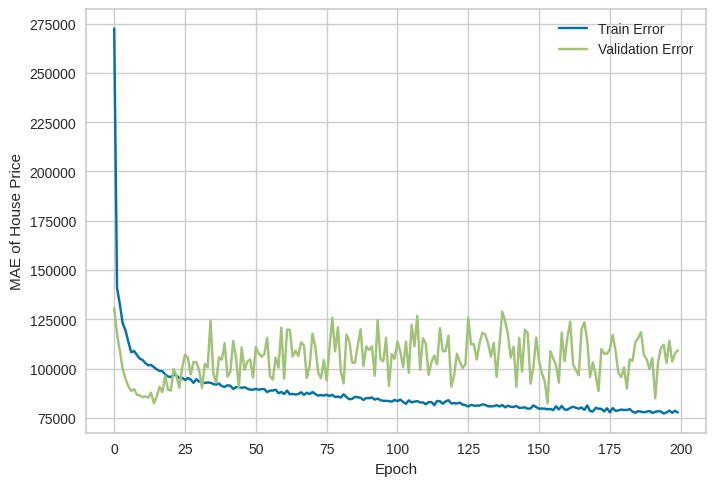

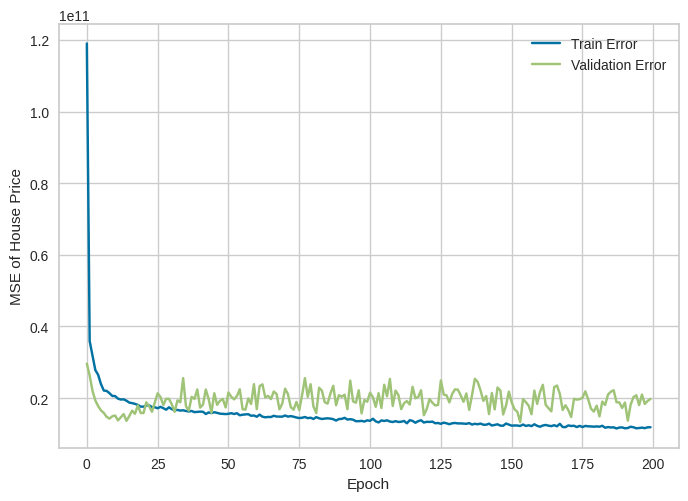

In [67]:
#Train and view model results, with early stopping
v5_history = v5_model.fit(X_norm_train, y_train,
                          epochs=200,
                          validation_split=.2,
                          verbose=0)
plot_results(v5_history)

v5_loss, v5_mae, v5_mse = v5_model.evaluate(X_norm_test, y_test, verbose=0)

print('Testing set Mean Abs Error: {:5.2f} dollars'.format(v5_mae))
print('Testing set Root Mean Squared Error: {:5.2f} dollars'.format(np.sqrt(v5_mse)))

Doesn't look like there was that much improvement, plus looks like a little overfitting based on the validation set MAE. The best model is still an MAE of 70,000. Not too bad, but needs some additional time and resources to improve. XGBoost still seems to be the better approach.